In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-01 by mza
name = "mza_try1"
num_epochs = 100
batch_size = 1000

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt

In [3]:
dataset = np.load('waveform_data_0.npy') # (10000, 104)
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
print("time_samples: " + str(time_samples))
print("num_truths: " + str(num_truths))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
print("waveforms: " + str(waveforms.shape))
#print("waveforms[0]: " + str(waveforms[0]))
print("truths: " + str(truths.shape))
#print("truths[0]: " + str(truths[0])) # t_peak, sigma, height, pedestal
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms))])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms))])
#print("waveform_max: " + str(waveform_max))
#print("waveform_min: " + str(waveform_min))
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
#print("offset: " + str(offset))
#print("gain: " + str(gain))
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
print("scaled_waveforms: " + str(scaled_waveforms.shape))
#print(str(scaled_waveforms[0]))
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
print("scaled_truths: " + str(scaled_truths.shape))
#print(str(scaled_truths[0]))

train_data = scaled_waveforms[:training_quantity,:]
print(str(train_data.shape))
train_truth = scaled_truths[:training_quantity,:]
print(str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print(str(test_data.shape))
test_truth = scaled_truths[training_quantity:,:]
print(str(test_truth.shape))
#print(sample_0)

num_waveforms: 10000
time_samples: 100
num_truths: 4
waveforms: (10000, 100)
truths: (10000, 4)
scaled_waveforms: (10000, 100)
scaled_truths: (10000, 4)
(8000, 100)
(8000, 4)
(2000, 100)
(2000, 4)


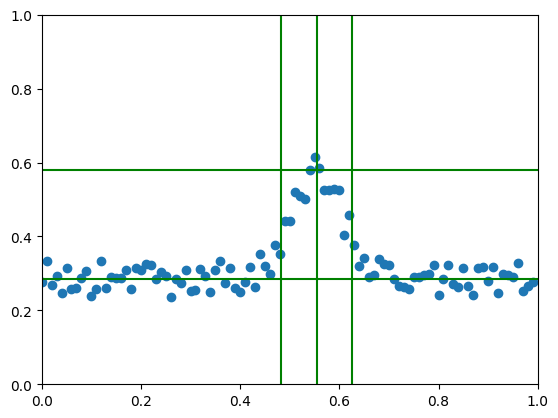

In [4]:
## Take a look at one event
# In each row (event), the 4th column to the 103th column are 100 data points of a single waveform
# Here we plot the first event:
evt = 7
x = np.zeros(time_samples)
for i in range(time_samples):
    x[i] = i/time_samples
y = train_data[evt]
plt.xlim(0, 1), plt.ylim(0, 1)
plt.scatter(x, y)
plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
plt.plot([train_truth[evt][0]-train_truth[evt][1], train_truth[evt][0]-train_truth[evt][1]], [0.0, 1.0], color="green")
plt.plot([train_truth[evt][0]+train_truth[evt][1], train_truth[evt][0]+train_truth[evt][1]], [0.0, 1.0], color="green")
plt.plot([0.0, 1.0], [train_truth[evt][2]+train_truth[evt][3], train_truth[evt][2]+train_truth[evt][3]], color="green")
plt.plot([0.0, 1.0], [train_truth[evt][3], train_truth[evt][3]], color="green")
plt.show()

In [5]:
## The truth
print("mean of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak
print("sigma of the peak: ", train_truth[evt][1]) # The 1st column: sigma of the Gaussian peak
print("height of the peak: ", train_truth[evt][2]) # The 2nd column: height of the Gaussian peak
print("pedestal of the waveform: ", train_truth[evt][3]) # The 3rd column: pedestal of the waveform

mean of the peak:  0.5540984344482421
sigma of the peak:  0.07178665161132812
height of the peak:  0.2936570646686683
pedestal of the waveform:  0.28576807869600074


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
model = Sequential()
model.add(QDense(100, input_shape=(100,), name='fc1', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QDense(100, name='fc1', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu1'))
model.add(QActivation(activation=quantized_sigmoid(16), name='sigmoid1'))
#model.add(QDense(64, name='fc2', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu2'))
model.add(QDense(32, name='fc3', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu3'))
model.add(QActivation(activation=quantized_sigmoid(16), name='sigmoid3'))
#model.add(QDense(24, name='fc3b', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu3b'))
#model.add(QDense(16, name='fc4', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(QActivation(activation=quantized_relu(16), name='relu4'))
model.add(QDense(4, name='output', kernel_quantizer=quantized_bits(16, 8, alpha=1), bias_quantizer=quantized_bits(16, 8, alpha=1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

In [8]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
if 0:
    # Here, 0.1 means that 10% of the weights will be forced to be 0.
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.1, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
train = True
if train:
    optimizer = optimizers.Adam(learning_rate=0.0001)
    #optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir=name,
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        train_data,
        train_truth,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co)

Epoch 1/100


/root/build/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


4/6 [===================>..........] - ETA: 0s - loss: 0.1557 - accuracy: 0.0865 
***callbacks***
saving losses to mza_try1/losses.log

Epoch 1: val_loss improved from inf to 0.15325, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.15325, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 1: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 3s 181ms/step - loss: 0.1552 - accuracy: 0.0840 - val_loss: 0.1532 - val_accuracy: 0.0850 - lr: 1.0000e-04
Epoch 2/100
4/6 [===================>..........] - ETA: 0s - loss: 0.1512 - accuracy: 0.0870

/root/build/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



***callbacks***
saving losses to mza_try1/losses.log

Epoch 2: val_loss improved from 0.15325 to 0.14947, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.15325 to 0.14947, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 2: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 2: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 48ms/step - loss: 0.1509 - accuracy: 0.0840 - val_loss: 0.1495 - val_accuracy: 0.0850 - lr: 1.0000e-04
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1473 - accuracy: 0.0834
***callbacks***
saving losses to mza_try1/losses.log

Epoch 3: val_loss improved from 0.14947 to 0.14522, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 3: val_loss improved from 0.14947 to 0.14522, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 3: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 3: 


Epoch 14: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 14: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 52ms/step - loss: 0.1255 - accuracy: 0.8252 - val_loss: 0.1250 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1248 - accuracy: 0.8212
***callbacks***
saving losses to mza_try1/losses.log

Epoch 15: val_loss improved from 0.12499 to 0.12413, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 15: val_loss improved from 0.12499 to 0.12413, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 15: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 15: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 49ms/step - loss: 0.1246 - accuracy: 0.8252 - val_loss: 0.1241 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 16/100
5/6 [===================

Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1167 - accuracy: 0.8278
***callbacks***
saving losses to mza_try1/losses.log

Epoch 27: val_loss improved from 0.11680 to 0.11621, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 0.11680 to 0.11621, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 27: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 27: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 59ms/step - loss: 0.1167 - accuracy: 0.8252 - val_loss: 0.1162 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1162 - accuracy: 0.8264
***callbacks***
saving losses to mza_try1/losses.log

Epoch 28: val_loss improved from 0.11621 to 0.11558, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 28: val_loss improved from 0.11621 to 0.11558, saving model to mza_try1/KERAS


Epoch 39: val_loss improved from 0.10953 to 0.10896, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 39: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 39: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 48ms/step - loss: 0.1095 - accuracy: 0.8252 - val_loss: 0.1090 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1089 - accuracy: 0.8254
***callbacks***
saving losses to mza_try1/losses.log

Epoch 40: val_loss improved from 0.10896 to 0.10837, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 40: val_loss improved from 0.10896 to 0.10837, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 40: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 40: saving model to mza_try1/KERAS_check_model_last_weights.h5

Epoch 40: saving model to mza_try1/KERAS_check_model_epoch40.h5

***callbacks end***

6/6 


Epoch 51: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 51: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 46ms/step - loss: 0.1026 - accuracy: 0.8252 - val_loss: 0.1021 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 52/100
6/6 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.8252
***callbacks***
saving losses to mza_try1/losses.log

Epoch 52: val_loss improved from 0.10209 to 0.10154, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 52: val_loss improved from 0.10209 to 0.10154, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 52: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 52: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 35ms/step - loss: 0.1021 - accuracy: 0.8252 - val_loss: 0.1015 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 53/100
6/6 [===================

Epoch 64/100
6/6 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.8252
***callbacks***
saving losses to mza_try1/losses.log

Epoch 64: val_loss improved from 0.09559 to 0.09505, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 64: val_loss improved from 0.09559 to 0.09505, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 64: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 64: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 44ms/step - loss: 0.0956 - accuracy: 0.8252 - val_loss: 0.0950 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 65/100
6/6 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.8252
***callbacks***
saving losses to mza_try1/losses.log

Epoch 65: val_loss improved from 0.09505 to 0.09453, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 65: val_loss improved from 0.09505 to 0.09453, saving model to mza_try1/KERAS


Epoch 76: val_loss improved from 0.08931 to 0.08881, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 76: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 76: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 40ms/step - loss: 0.0893 - accuracy: 0.8252 - val_loss: 0.0888 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0889 - accuracy: 0.8262
***callbacks***
saving losses to mza_try1/losses.log

Epoch 77: val_loss improved from 0.08881 to 0.08830, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 77: val_loss improved from 0.08881 to 0.08830, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 77: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 77: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 54ms/step - loss: 0.0888 - 


Epoch 88: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 52ms/step - loss: 0.0833 - accuracy: 0.8252 - val_loss: 0.0828 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 89/100
6/6 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.8252
***callbacks***
saving losses to mza_try1/losses.log

Epoch 89: val_loss improved from 0.08281 to 0.08231, saving model to mza_try1/KERAS_check_best_model.h5

Epoch 89: val_loss improved from 0.08281 to 0.08231, saving model to mza_try1/KERAS_check_best_model_weights.h5

Epoch 89: saving model to mza_try1/KERAS_check_model_last.h5

Epoch 89: saving model to mza_try1/KERAS_check_model_last_weights.h5

***callbacks end***

6/6 [==============================] - 0s 38ms/step - loss: 0.0828 - accuracy: 0.8252 - val_loss: 0.0823 - val_accuracy: 0.8265 - lr: 1.0000e-04
Epoch 90/100
6/6 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.8252
***ca

In [10]:
print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
y_keras = model.predict(test_data)
print(str(y_keras[0]) + " : " + str(test_truth[0]))

test_acc: 0.821, test_loss: 0.077
63/63 [==============================] - 1s 2ms/step
[0.4807621  0.04073853 0.25706863 0.22143087] : [0.54149693 0.09774141 0.22505841 0.20915764]


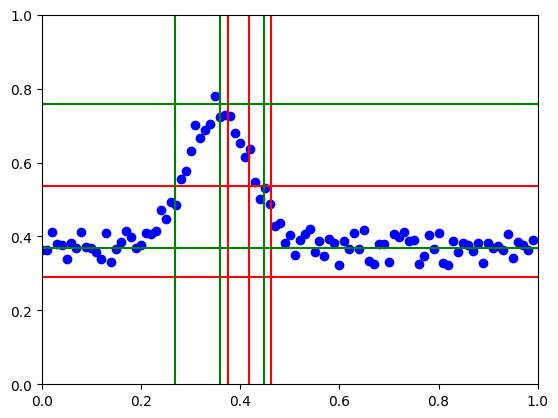

In [11]:
evt = 4
x = np.zeros(time_samples)
for i in range(time_samples):
    x[i] = i/time_samples
y = test_data[evt]
plt.xlim(0, 1), plt.ylim(0, 1)
plt.scatter(x, y, color="blue")
plt.plot([y_keras[evt][0], y_keras[evt][0]], [0.0, 1.0], color="red")
plt.plot([y_keras[evt][0]-y_keras[evt][1], y_keras[evt][0]-y_keras[evt][1]], [0.0, 1.0], color="red")
plt.plot([y_keras[evt][0]+y_keras[evt][1], y_keras[evt][0]+y_keras[evt][1]], [0.0, 1.0], color="red")
plt.plot([0.0, 1.0], [y_keras[evt][2]+y_keras[evt][3], y_keras[evt][2]+y_keras[evt][3]], color="red")
plt.plot([0.0, 1.0], [y_keras[evt][3], y_keras[evt][3]], color="red")
plt.plot([test_truth[evt][0], test_truth[evt][0]], [0.0, 1.0], color="green")
plt.plot([test_truth[evt][0]-test_truth[evt][1], test_truth[evt][0]-test_truth[evt][1]], [0.0, 1.0], color="green")
plt.plot([test_truth[evt][0]+test_truth[evt][1], test_truth[evt][0]+test_truth[evt][1]], [0.0, 1.0], color="green")
plt.plot([0.0, 1.0], [test_truth[evt][2]+test_truth[evt][3], test_truth[evt][2]+test_truth[evt][3]], color="green")
plt.plot([0.0, 1.0], [test_truth[evt][3], test_truth[evt][3]], color="green")
plt.show()

In [12]:
#y_keras_sig = y_keras[ (test_truth >= 0) ]
#y_keras_bkg = y_keras[ (test_truth < 1) ]
#plt.figure(figsize=(6,6))
#plt.hist(y_keras_bkg,log=True,bins=50,label='label == 0',alpha=0.5,color='blue')
#plt.hist(y_keras_sig,log=True,bins=50,label='label == 1',alpha=0.5,color='red')
#plt.legend().get_frame().set_alpha(0)
#plt.xlabel('y_keras')
#plt.show()